In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
import copy
import matplotlib.pyplot as plt
import torchvision
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
import time
import os
from sklearn.model_selection import cross_val_score
from skorch import NeuralNetClassifier
from efficientnet_pytorch import EfficientNet # still planning to use
print(torch.__version__)
torch.cuda.is_available()

1.7.0


True

In [2]:
torch.manual_seed(123)

In [3]:
data_dir = 'content'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
device = torch.device('cpu')
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 38)
model.to(device)
criterion = nn.CrossEntropyLoss()
optmizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optmizer,step_size=7, gamma=0.1)

model = train_model(model, criterion, optmizer, step_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.9076 Acc: 0.2957
val Loss: 2.0690 Acc: 0.6561

Epoch 1/9
----------
train Loss: 1.9177 Acc: 0.5488
val Loss: 1.9417 Acc: 0.7363

Epoch 2/9
----------
train Loss: 1.5317 Acc: 0.6238
val Loss: 2.0024 Acc: 0.7616

Epoch 3/9
----------
train Loss: 1.3415 Acc: 0.6586
val Loss: 2.1392 Acc: 0.7711

Epoch 4/9
----------
train Loss: 1.2242 Acc: 0.6812
val Loss: 2.0566 Acc: 0.7611

Epoch 5/9
----------
train Loss: 1.1497 Acc: 0.6949
val Loss: 2.3169 Acc: 0.7785

Epoch 6/9
----------
train Loss: 1.0739 Acc: 0.7169
val Loss: 2.2214 Acc: 0.7843

Epoch 7/9
----------
train Loss: 1.0250 Acc: 0.7188
val Loss: 2.1869 Acc: 0.7874

Epoch 8/9
----------
train Loss: 0.9897 Acc: 0.7392
val Loss: 2.1068 Acc: 0.7822

Epoch 9/9
----------
train Loss: 0.9959 Acc: 0.7339
val Loss: 2.2423 Acc: 0.7838

Training complete in 58m 14s
Best val Acc: 0.787447


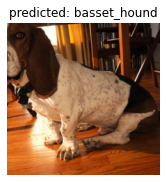

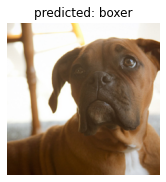

In [38]:
# save the model so you can easily load later
# load with: model.load_state_dict(torch.load(PATH))
PATH = './resnet18_38_classes.pth'
torch.save(model.state_dict(), PATH)

In [77]:
def return_model_answer(img_path):
    #INSANE casting to the model stupidly done by me in almost 1 day of work (it was my first day on PyTorch ok)
    model.eval()
    import cv2
    from PIL import Image
    img = img_path
    img_test = Image.open(img)
    plt.imshow(img_test)
    plt.show()
    img_test = img_test.resize((224,224))
    img_test = np.array(img_test.getdata()).reshape(*img_test.size,3)
    img_test = img_test/255
    img_test = img_test.transpose(2,0,1)
    img_test = img_test[None,:,:,:]
    img = torch.from_numpy(img_test)
    #img= img.cuda() # Disabled since the model don't use gpu (my 1050ti 4gb can't handle it)
    img = img.float()
    # pass to CNN to recognize it
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)
    return (format(class_names[predicted]))

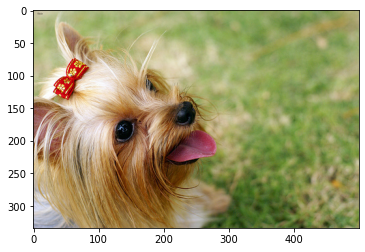

scottish_terrier


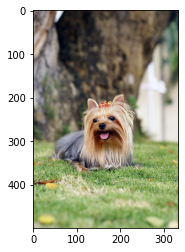

yorkshire_terrier


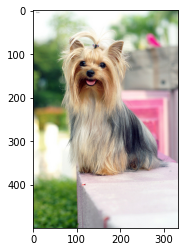

havanese


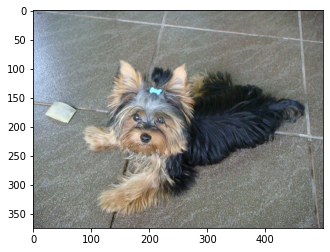

yorkshire_terrier


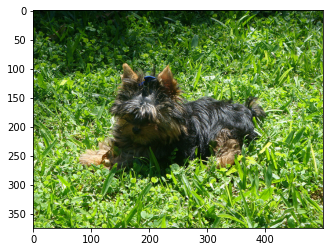

scottish_terrier


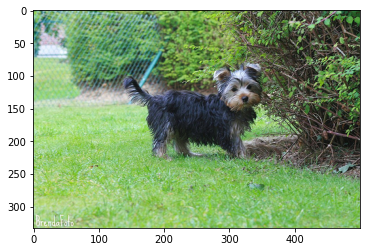

scottish_terrier


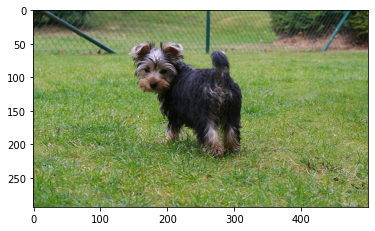

scottish_terrier


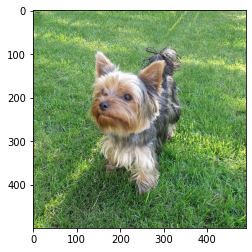

yorkshire_terrier


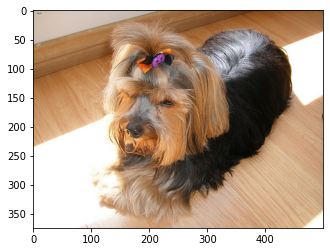

havanese


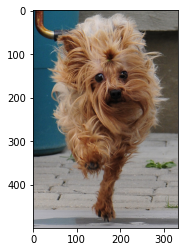

wheaten_terrier


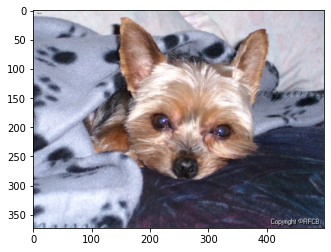

yorkshire_terrier


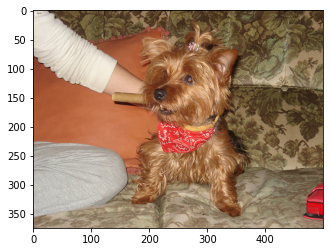

scottish_terrier


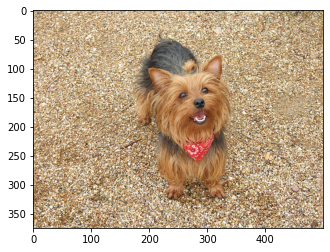

scottish_terrier


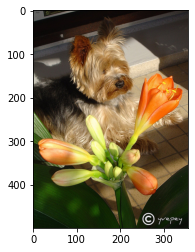

wheaten_terrier


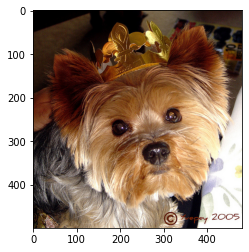

yorkshire_terrier


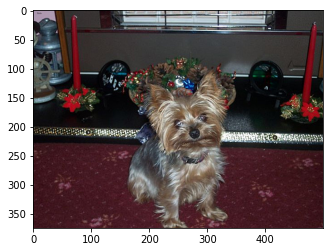

scottish_terrier


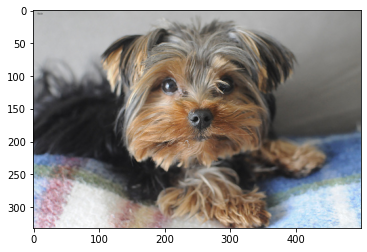

yorkshire_terrier


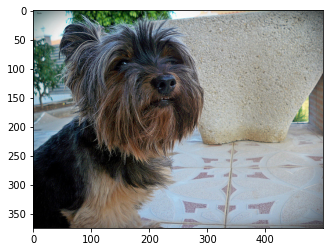

scottish_terrier


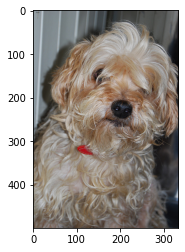

wheaten_terrier


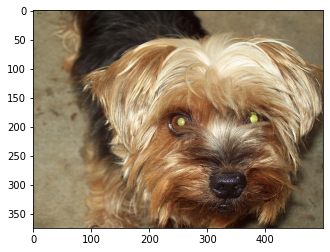

scottish_terrier


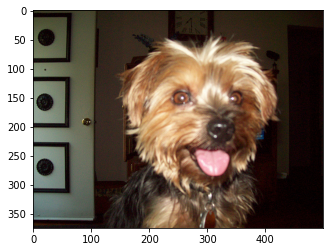

yorkshire_terrier


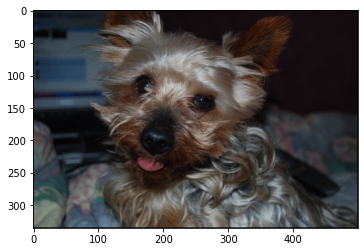

scottish_terrier


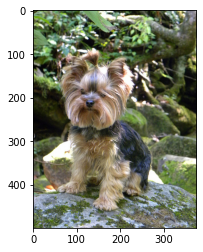

scottish_terrier


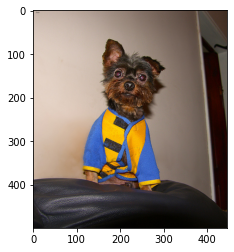

scottish_terrier


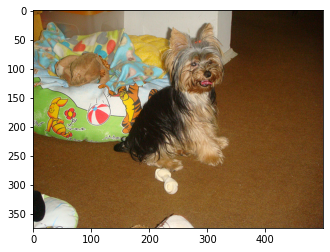

Sphynx


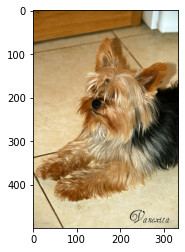

havanese


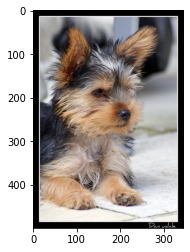

scottish_terrier


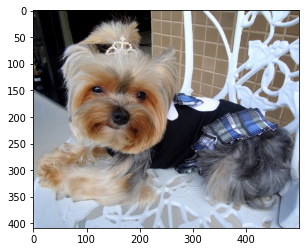

yorkshire_terrier


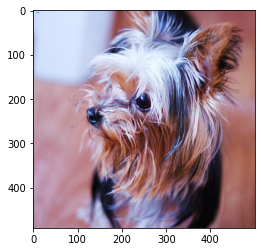

scottish_terrier


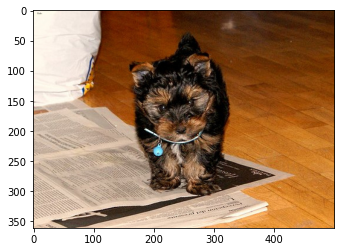

Maine_Coon


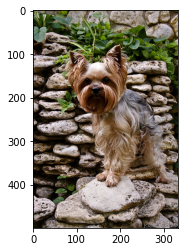

wheaten_terrier


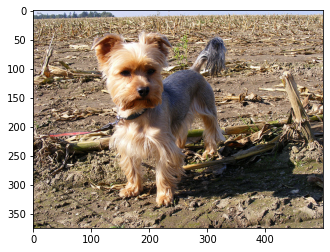

scottish_terrier


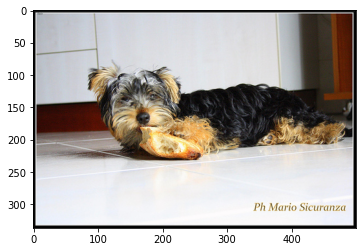

wheaten_terrier


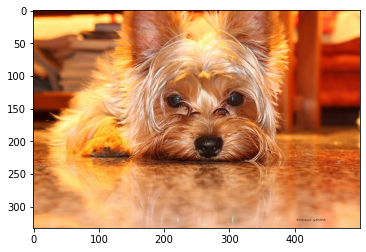

scottish_terrier


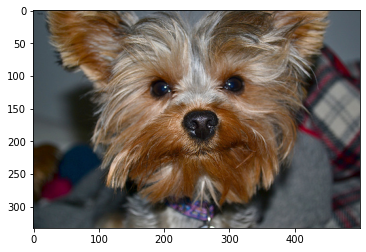

yorkshire_terrier


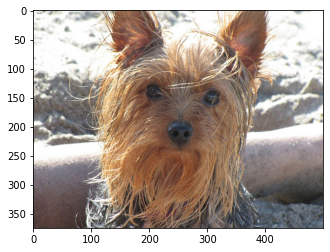

scottish_terrier


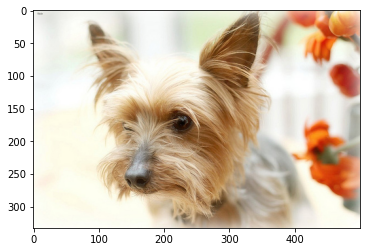

scottish_terrier


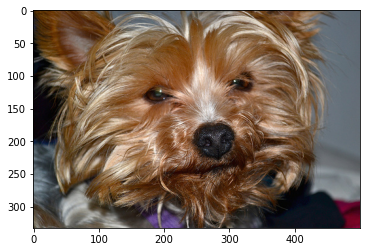

scottish_terrier


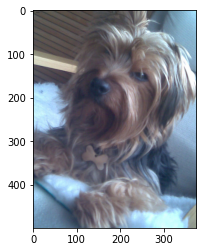

scottish_terrier


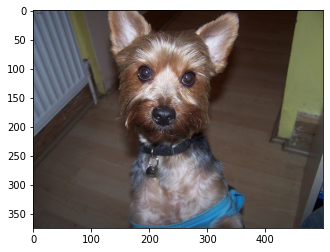

yorkshire_terrier


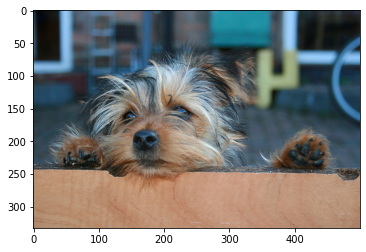

yorkshire_terrier


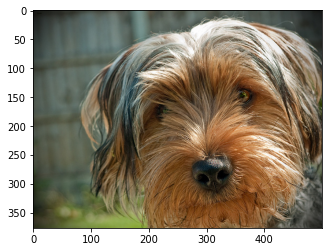

havanese


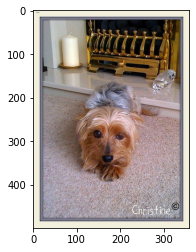

yorkshire_terrier


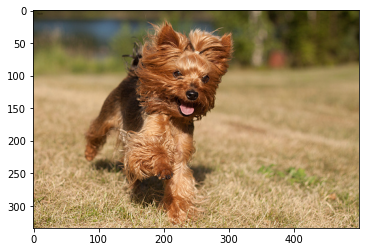

scottish_terrier


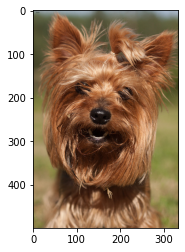

scottish_terrier


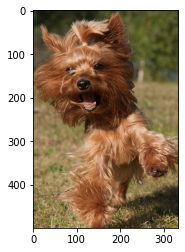

scottish_terrier


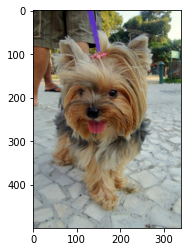

yorkshire_terrier


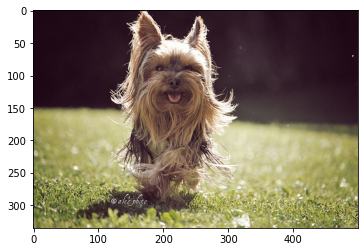

scottish_terrier


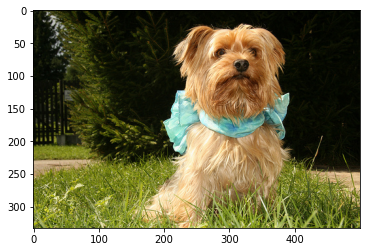

wheaten_terrier


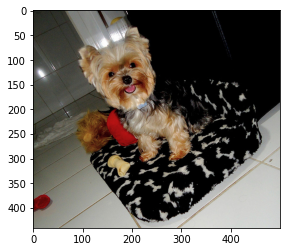

yorkshire_terrier
yorkshire_terrier accuracy: 28.00%


In [123]:
breed = 'yorkshire_terrier' #just switch the breed and run the val tests
val_dir = '/home/gabriel/Documentos/ML/EfficientNet/content/val/'
count = 0
samples = 0
for i in range(1,51):
    try:
        name = val_dir + breed + '/' + breed + '_' + str(i) + '.jpg'
        answer = return_model_answer(name)
        print(answer)
        samples+=1
        if answer == breed:
            count+=1
    except:
        pass
breed_accuracy ="%.2f" % ((count/samples)*100)
print(breed + ' accuracy: ' + breed_accuracy + '%')